In [81]:
# Импортирую необходимые библиотеки
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---

**Описание данных**

Таблица user_info:
- `user_id` - id пользователя
- `order_id` - id заказа
- `action` - действие пользователя (создание или отмена заказа)
- `time` - дата и время заказа
- `date` - дата заказа
- `group` - группа (1 - Новая система рекомендаций; 0 - Старая система рекомендаций)

Таблица orders:
- `order_id` - id заказа
- `creation_time` - дата и время создания заказа
- `product_ids` - массив с id продуктов

Таблица products:
- `product_id` - id продукта
- `name` - название продукта
- `price` - цена продукта

---

## Этап 0: Загрузка и Предобработка Данных

In [82]:
user_info = pd.read_csv('ab_users_data.csv', parse_dates = ['time', 'date'])

In [83]:
user_info.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [84]:
print(f'Размер датафрейма: {user_info.shape}\n\nТипы данных:\n{user_info.dtypes}\n\nПропущенные значения:\n{user_info.isna().sum()}\n\nУникальные значения:\n{user_info.nunique()}')

Размер датафрейма: (4337, 6)

Типы данных:
user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

Пропущенные значения:
user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

Уникальные значения:
user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64


---

In [85]:
orders = pd.read_csv('ab_orders.csv', parse_dates = ['creation_time'])

In [86]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [87]:
print(f'Размер датафрейма: {orders.shape}\n\nТипы данных:\n{orders.dtypes}\n\nПропущенные значения:\n{orders.isna().sum()}\n\nУникальные значения:\n{orders.nunique()}')

Размер датафрейма: (4123, 3)

Типы данных:
order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

Пропущенные значения:
order_id         0
creation_time    0
product_ids      0
dtype: int64

Уникальные значения:
order_id         4123
creation_time    4098
product_ids      3877
dtype: int64


---

In [88]:
products = pd.read_csv('ab_products.csv')

In [89]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [90]:
print(f'Размер датафрейма: {products.shape}\n\nТипы данных:\n{products.dtypes}\n\nПропущенные значения:\n{products.isna().sum()}\n\nУникальные значения:\n{products.nunique()}')

Размер датафрейма: (87, 3)

Типы данных:
product_id      int64
name           object
price         float64
dtype: object

Пропущенные значения:
product_id    0
name          0
price         0
dtype: int64

Уникальные значения:
product_id    87
name          87
price         63
dtype: int64


**Проверим, сколько уникальных пользователей учавствовало в каждой из групп**

In [91]:
print(f'Кол-во уникальных пользователей в контрольной группе: {user_info.query("group == 0").user_id.nunique()} человек\nКол-во уникальных пользователей в экспериментальной группе: {user_info.query("group == 1").user_id.nunique()} человека')

Кол-во уникальных пользователей в контрольной группе: 515 человек
Кол-во уникальных пользователей в экспериментальной группе: 502 человека


Видно, что кол-во человек в группах примерно одинаково.

---

## Этап 1: Оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения

*Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.*

### 1.2: Выбор ключевых метрик

*Ключевая цель любого бизнеса - деньги. Поэтому, те решения, которые внедряются в приложение/сервис должны прямо или косвенно быть направлены на увеличение дохода. Ключевые метрики, которые стоит проверить: средний чек, количество заказов в день, возвращаемость клиентов (retention)*

### Средний Чек Заказа (AOV)

Во-первых, попробуем посмотреть, изменился ли средний чек в двух группах.

Также, будем работать с заказами, которые не были отменены

Так как колонка product_ids представлена не в виде питоновского массива, то преобразуем ее.

In [92]:
# преобразовываем значения в массив чисел
orders['product_ids'] = orders.product_ids.str.strip('{}')  # удаляем скобки
orders['product_ids'] = orders.product_ids.str.split(',').apply(lambda x: [int(i) for i in x])  # разбиваем строку и преобразуем в числа

In [93]:
accepted_orders_info = user_info \
    .query('action != "cancel_order"') \
    .merge(orders, on = 'order_id', how = 'left') \
    .explode('product_ids') \
    .rename(columns = {'product_ids': 'product_id'}) \
    .merge(products, on = 'product_id', how = 'left')

In [94]:
accepted_orders_info.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0


In [95]:
aov = accepted_orders_info \
    .groupby(['order_id', 'date', 'group'], as_index = False) \
    .agg({'price': 'sum'}) \
    .pivot_table(index = 'date', columns = 'group', values = 'price', aggfunc = 'mean') \
    .rename(columns = {0: 'control', 1: 'experimental'})

In [96]:
aov

group,control,experimental
date,,
2022-08-26,381.846019,359.925109
2022-08-27,375.962500,384.411282
2022-08-28,350.365217,371.211483
2022-08-29,406.533929,383.579130
2022-08-30,357.126531,343.498758
2022-08-31,412.923881,373.987200
2022-09-01,391.267105,368.436765
2022-09-02,435.177922,374.567857
2022-09-03,402.216667,404.117219


*Получили метрику AOV, но пока непонятно, в какой группе средний чек больше. Визуализируем данные*

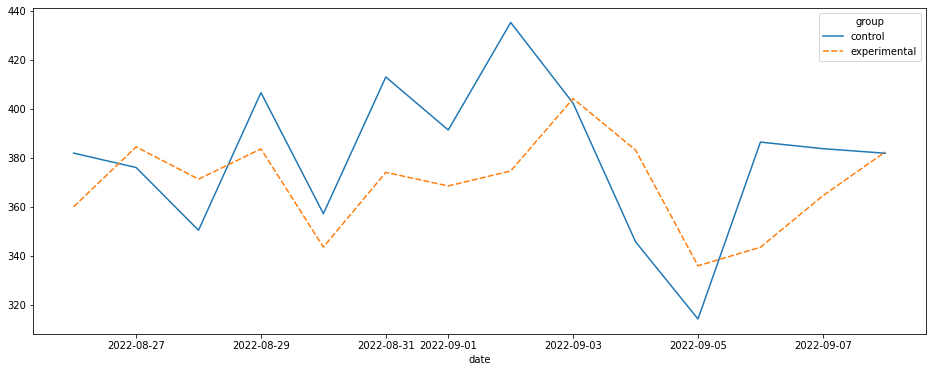

In [97]:
plt.figure(figsize = (16, 6))
sns.lineplot(data = aov)

*Сложно сделать какой-либо вывод по данному графику. Заметно, что в целом в группе `control` средний чек выше. Но надо убедиться в этом с помощью статистических тестов. Во-первых, необходимо проверить наши выборки на нормальность, а затем выбрать тест.*

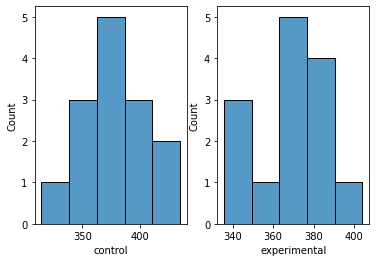

In [98]:
fig, ax = plt.subplots(1, 2)
sns.histplot(aov['control'], ax = ax[0])
sns.histplot(aov['experimental'], ax = ax[1])

*Нулевая гипотеза - Распределение является нормальным; Альтернативная гипотеза утверждает обратное.*

In [99]:
if stats.shapiro(aov['control'])[1] < 0.05:
    print(f'p-value: {np.round(stats.shapiro(aov["control"])[1], 2)} | Есть основание отклонить нулевую гипотезу.')
else:
    print(f'p-value: {np.round(stats.shapiro(aov["control"])[1], 2)} | Нет оснований отклонить нулевую гипотезу.')


p-value: 0.92 | Нет оснований отклонить нулевую гипотезу.


In [100]:
if stats.shapiro(aov['experimental'])[1] < 0.05:
    print(f'p-value: {np.round(stats.shapiro(aov["experimental"])[1], 2)} | Есть основание отклонить нулевую гипотезу.')
else:
    print(f'p-value: {np.round(stats.shapiro(aov["experimental"])[1], 2)} | Нет оснований отклонить нулевую гипотезу.')

p-value: 0.53 | Нет оснований отклонить нулевую гипотезу.


*Так как выборки маленькие, использовал тест Шапиро-Уилка на нормальность распределения. Тест проверяет нулевую гипотезу, что распределение нормально.*

*Теперь можно сравнить AOV в обеих группах с помощью T-теста, который проверяет нулевую гипотезу о равенстве средних.*

In [101]:
if stats.ttest_ind(aov['control'], aov['experimental'])[1] < 0.05:
    print(f"p-value: {np.round(stats.ttest_ind(aov['control'], aov['experimental'])[1], 2)} | Есть основание отклонить нулевую гипотезу")
else:
    print(f"p-value: {np.round(stats.ttest_ind(aov['control'], aov['experimental'])[1], 2)} | Нет оснований отклонить нулевую гипотезу")

p-value: 0.27 | Нет оснований отклонить нулевую гипотезу


Результат теста: p-value = 0.27, что больше порога значимости 0.05. Значит, средний чек в этих группах статистически не различается

### Вывод: Новый алгоритм не повлиял на средний чек заказа

---

*Решил копнуть дальше и посмотреть, есть ли отличия в суммах каждого заказа*

**Суммарный чека заказов**

In [149]:
orders_value = accepted_orders_info \
    .groupby(['order_id', 'group'], as_index = False) \
    .agg({'price': 'sum'}) \
    .pivot(index = 'order_id', columns = 'group', values = 'price') \
    .rename(columns = {0: 'control', 1: 'experimental'})

In [150]:
orders_value.mean()

group
control         381.285768
experimental    369.622912
dtype: float64

*Предварительно можно сказать, что в экспериментальной группе средний чек у заказов меньше, чем в контрольной группе. Удостоверюсь в этом с помощью статистических тестов.*

*Построю на распределение суммы чеков заказов для двух групп*

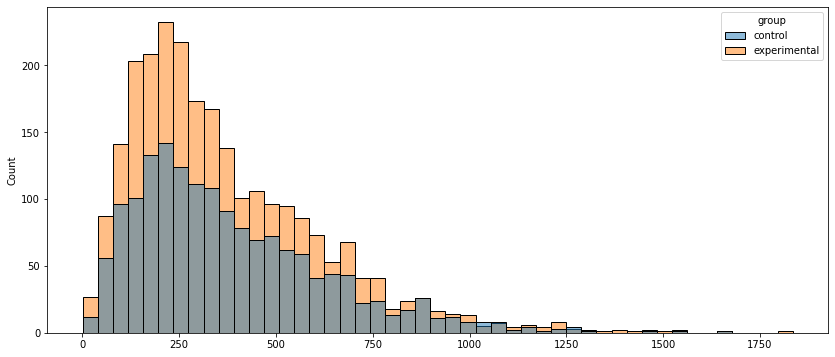

In [104]:
plt.figure(figsize = (14, 6))
sns.histplot(orders_value)

*Заметно, что распределение не сильно похоже на нормальное, что дает ограничение в применении некоторых тестов. Также, проверю распределения на нормальность с потощью метода normaltest из библиотеки scipy*

In [152]:
if stats.normaltest(orders_value['control'].dropna())[1] < 0.05:
    print(f'p-value: {stats.normaltest(orders_value["control"].dropna())[1]} | Есть основания отклонить нулевую гипотезу о нормальности распределения')
else:
    print(f'p-value: {stats.normaltest(orders_value["control"].dropna())[1]} | Нет основания отклонить нулевую гипотезу о нормальности распределения')

p-value: 2.122196897492167e-63 | Есть основания отклонить нулевую гипотезу о нормальности распределения


*Попробую добиться нормальности распределения с помощью логарифмирования значений.*

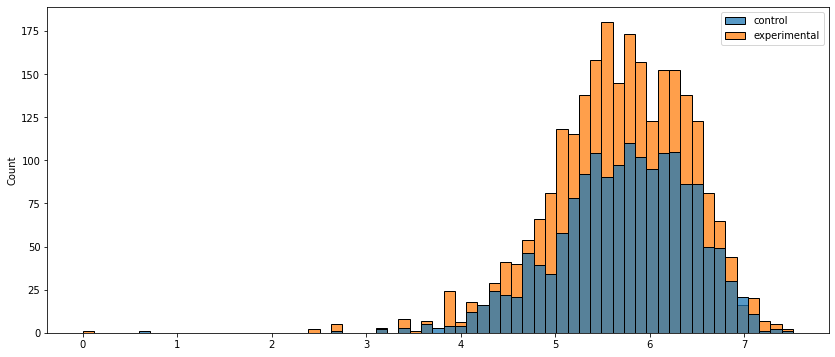

In [106]:
plt.figure(figsize = (14, 6))
sns.histplot([np.log(orders_value['control'].dropna()), np.log(orders_value['experimental'].dropna())])

*Получилось что-то похоже на нормальное распределение, но также имеются выбросы*

*Теперь, зная характер нашего распределения можем применять два статистических теста: 1 - Критерий Манна-Уитни, который сравнивает два распределения между собой (не средние; не медианы); 2 - t-тест, для нормального распределения, который сравнит средние значения*

In [107]:
if stats.ttest_ind(np.log(orders_value['control'].dropna()), np.log(orders_value['experimental'].dropna()))[1] < 0.05:
    print(f"""T-Test: p-value: {stats.ttest_ind(np.log(orders_value['control'].dropna()), np.log(orders_value['experimental'].dropna()))[1]}
Есть основания отклонить нулевую гипотезу о равенстве средних
           """)
else:
     print(f"""T-Test: p-value: {stats.ttest_ind(np.log(orders_value['control'].dropna()), np.log(orders_value['experimental'].dropna()))[1]}
Нет оснований отклонить нулевую гипотезу о равенстве средних""")

T-Test: p-value: 0.07206829022429478
Нет оснований отклонить нулевую гипотезу о равенстве средних


In [109]:
if stats.mannwhitneyu(orders_value['control'].dropna(), orders_value['experimental'].dropna())[1] < 0.05:
    print(f"""MW-Test: p-value: {stats.mannwhitneyu(orders_value['control'].dropna(), orders_value['experimental'].dropna())[1]}
Есть основания отклонить нулевую гипотезу о равенстве распределений
           """)
else:
     print(f"""MW-Test: p-value: {stats.mannwhitneyu(orders_value['control'].dropna(), orders_value['experimental'].dropna())[1]}
Нет оснований отклонить нулевую гипотезу о равенстве распределений""")

MW-Test: p-value: 0.07092841758633131
Нет оснований отклонить нулевую гипотезу о равенстве распределений


**Дальше, мне интересно было проверить, а как ведет себя p-value начиная со дня старта эксперимента**

In [110]:
accepted_orders_info

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0
...,...,...,...,...,...,...,...,...,...,...
13821,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,9,чай черный листовой,83.5
13822,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,62,сок яблочный,120.0
13823,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,77,курица,298.4
13824,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,0,2022-09-08 23:41:24,17,морс брусничный,190.0


In [111]:
orders_value_by_date = pd.DataFrame()
stats_results = pd.DataFrame()

In [112]:
for day in accepted_orders_info.date.unique():
    
    orders_value = accepted_orders_info[accepted_orders_info.date == day].pivot_table(index = 'order_id', columns = 'group', values = 'price', aggfunc = 'sum')
    orders_value_by_date = orders_value_by_date.append(orders_value)
    
    fit = stats.mannwhitneyu(orders_value_by_date[0].dropna(),
                             orders_value_by_date[1].dropna())
    
    stats_results = stats_results.append(pd.DataFrame({'stat': [fit[0]], 'p': [fit[1]], 'date': day}))

*Тут я реализовал цикл, который для каждого дня считатет сумму заказов и записывает их в пустой датафрейм. Затем я использую критерий Манна-Уитни чтобы сравнить эти распределения для всех дней и ниже вывел график зависимости p-value от даты*

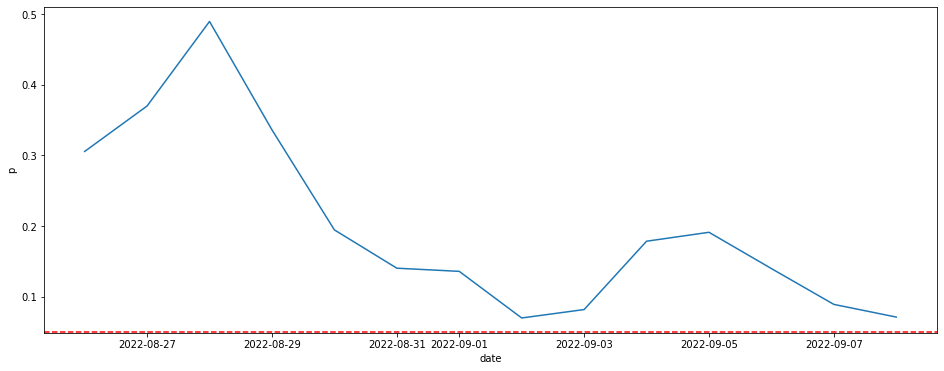

In [113]:
plt.figure(figsize = (16, 6))
ax = sns.lineplot(data = stats_results, x = 'date', y = 'p')
ax.axhline(0.05, ls='--', color='red')

### Вывод:
    1. Как было отмечено ранее, новый алгорит не повлиял на средний чек заказа в данном эксперименте
    2. Как следствие, сумма заказов тоже не стат. значимо отличается в этих группах.
    3. Возможно, продолжительность теста или выборка была недостаточной, так как заметно, что p-value флуктуации достаточно сильные.

---

### Количество Заказов

Посмотрим, как менялось количество заказов в двух группах.

Для анализа я буду использовать только не заказы, которые не отменялись.

In [114]:
accepted_orders_info.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0


In [115]:
orders_count = accepted_orders_info \
    .pivot_table(index = 'date', columns = 'group', values = 'order_id', aggfunc = 'nunique') \
    .rename(columns = {0: 'control', 1: 'experimental'})

In [116]:
orders_count

group,control,experimental
date,,
2022-08-26,628,689
2022-08-27,112,195
2022-08-28,92,209
2022-08-29,112,230
2022-08-30,98,161
2022-08-31,67,125
2022-09-01,76,136
2022-09-02,77,140
2022-09-03,66,151


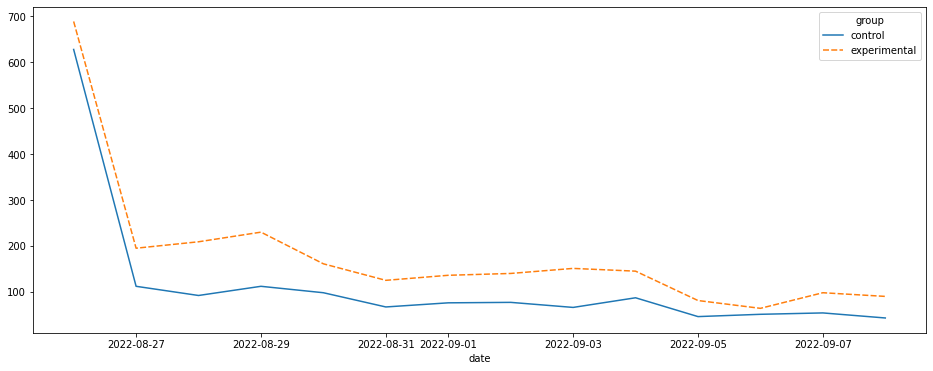

In [117]:
plt.figure(figsize = (16, 6))
sns.lineplot(data = orders_count)

*Здесь уже ситуация заметнее. Предворительный вывод, что в экспериментальной группе кол-во заказов увеличилось. Проверим*

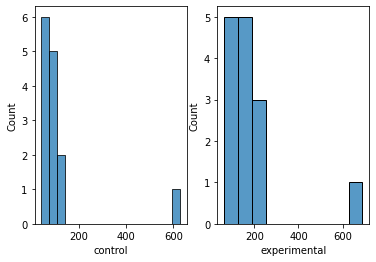

In [118]:
fig, ax = plt.subplots(1, 2)
sns.histplot(orders_count['control'], ax = ax[0])
sns.histplot(orders_count['experimental'], ax = ax[1])

*Заметно, что характер обоих распределений - ненормальный, также есть заметный выброс. (В день начала эксперимента кол-во заказов больше, чем в остальные дни)*

**Для оценки различий буду использовать критерий Манна-Уитни**

In [155]:
if stats.mannwhitneyu(orders_count['control'], orders_count['experimental'])[1] < 0.05:
    print(f"p-value: {np.round(stats.mannwhitneyu(orders_count['control'], orders_count['experimental'])[1], 4)} | Есть основания отклонять нулевую гипотезу")
else:
    print(f"p-value: {np.round(stats.mannwhitneyu(orders_count['control'], orders_count['experimental'])[1], 4)} | Нет оснований отклонять нулевую гипотезу")

p-value: 0.0033 | Есть основания отклонять нулевую гипотезу


*p уровень значимости получился равным 0.003, что меньше чем 0.05. Значит есть основание отклонить нулевую гипотезу о равенстве распределений.*

### Вывод: новый алгоритм увеличил кол-во заказов, которые делают пользователи.

**Интересно посмотреть, сколько уникальных заказов совершает пользователи в каждой из групп**

In [120]:
orders_per_user = accepted_orders_info \
    .pivot_table(index = 'user_id', columns = 'group', values = 'order_id', aggfunc = 'nunique') \
    .rename(columns = {0: 'control', 1: 'experimental'})

In [121]:
orders_per_user.head()

group,control,experimental
user_id,,
964,2.0,NaN
965,NaN,9.0
966,1.0,NaN
967,NaN,5.0
968,3.0,NaN


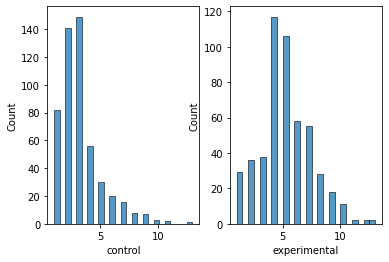

In [122]:
fig, ax = plt.subplots(1, 2)

sns.histplot(orders_per_user['control'], ax = ax[0])
sns.histplot(orders_per_user['experimental'], ax = ax[1])

*Контрольная группа - видно, что распредение ненормальное; Экспериментальная группа - распределение больше похоже на нормальное*

In [123]:
stats.normaltest(orders_per_user['control'].dropna())

NormaltestResult(statistic=168.68174543124155, pvalue=2.350847085591091e-37)

In [124]:
stats.normaltest(orders_per_user['experimental'].dropna())

NormaltestResult(statistic=21.897130007276793, pvalue=1.7583229075690624e-05)

*Делаем вывод, что нулевую гипотезу, о нормальности распределения, отклоняем. Значит, воспользуюсь критерием Манна-Уитни для того, чтобы найти различия в этих группах*

In [125]:
stats.mannwhitneyu(orders_per_user['control'].dropna(),
                   orders_per_user['experimental'].dropna())

MannwhitneyuResult(statistic=61172.5, pvalue=6.987139829766148e-49)

*p-value получился меньше чем 0.05, значит две группы стат. значимо различаются. Что еще раз подверждает гипотезу о том, что в экспериментальной группе делают больше заказов*

**Можно посмотреть как изменяется p-value по дате эксперимента**

In [126]:
orders_num_by_date = pd.DataFrame()
stats_results = pd.DataFrame()

In [127]:
for day in accepted_orders_info.date.unique():
    
    order_num = accepted_orders_info[accepted_orders_info.date == day].pivot_table(index = 'user_id', columns = 'group', values = 'order_id', aggfunc = 'nunique')
    orders_num_by_date = orders_num_by_date.append(order_num)
    
    fit = stats.mannwhitneyu(orders_num_by_date[0].dropna(),
                             orders_num_by_date[1].dropna())
    
    stats_results = stats_results.append(pd.DataFrame({'stat': [fit[0]], 'p': [fit[1]], 'date': day}))

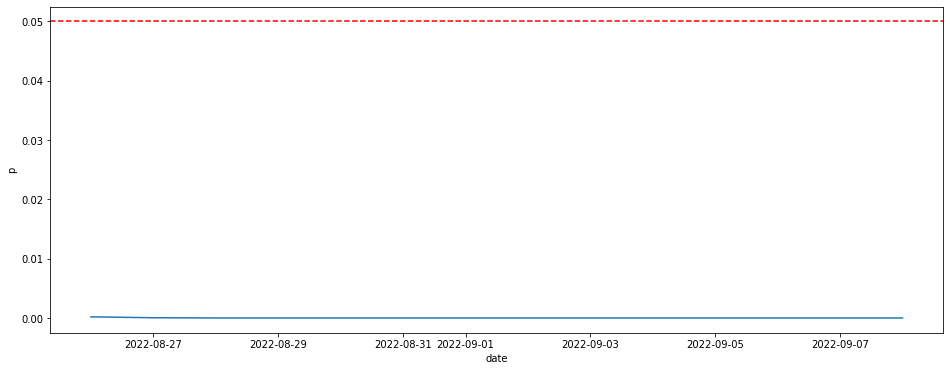

In [128]:
plt.figure(figsize = (16, 6))
ax = sns.lineplot(data = stats_results, x = 'date', y = 'p')
ax.axhline(0.05, ls='--', color='red')

### Вывод:
    1. С новым алгоритмом кол-во заказов увеличилось у пользователей увеличилось и эти различия стат. значимы.

---

### Retention Rate

Алгоритм действий:
    1. Разделить пользователей на 2 группы и отдельно работать с ними
    2. Для каждого пользователя найти дату первого заказа - это и будет нашей когортой
    3. Посчитать максимальное число пользователей в каждой когорте, для того, чтобы найти отношение пользователей
    4. Найти разницу между датой и первой датой заказа, для более удобного представления

*Контрольная группа - без алгоритма*

In [129]:
accepted_orders_info.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0


In [130]:
first_orders_control = accepted_orders_info.query('group == 0')[['user_id', 'date']]

In [131]:
first_orders_control['first_order_date'] = first_orders_control.groupby('user_id')['date'].transform(min)

In [132]:
first_orders_control.head()

,user_id,date,first_order_date
0,964,2022-08-26,2022-08-26
1,964,2022-08-26,2022-08-26
2,964,2022-08-26,2022-08-26
3,964,2022-08-26,2022-08-26
7,964,2022-08-26,2022-08-26


In [133]:
retention_rate_control = first_orders_control \
    .groupby(['first_order_date', 'date'], as_index = False) \
    .agg({'user_id': 'nunique'}) \
    .rename(columns = {'user_id': 'users_count'})

retention_rate_control['max_users'] = retention_rate_control.groupby('first_order_date')['users_count'].transform(max)

retention_rate_control = retention_rate_control.assign(users_share = retention_rate_control.users_count / retention_rate_control.max_users)

retention_rate_control['days_diff'] = (retention_rate_control.date - retention_rate_control.first_order_date).dt.days

In [134]:
retention_rate_control

,first_order_date,date,users_count,max_users,users_share,days_diff
0,2022-08-26,2022-08-26,515,515,1.000000,0
1,2022-08-26,2022-08-27,86,515,0.166990,1
2,2022-08-26,2022-08-28,71,515,0.137864,2
3,2022-08-26,2022-08-29,87,515,0.168932,3
4,2022-08-26,2022-08-30,74,515,0.143689,4
5,2022-08-26,2022-08-31,56,515,0.108738,5
6,2022-08-26,2022-09-01,60,515,0.116505,6
7,2022-08-26,2022-09-02,54,515,0.104854,7
8,2022-08-26,2022-09-03,50,515,0.097087,8
9,2022-08-26,2022-09-04,63,515,0.122330,9


*Видно, что в данных только одна когорта пользователей, который совершили свой первый заказ 2022-08-26*

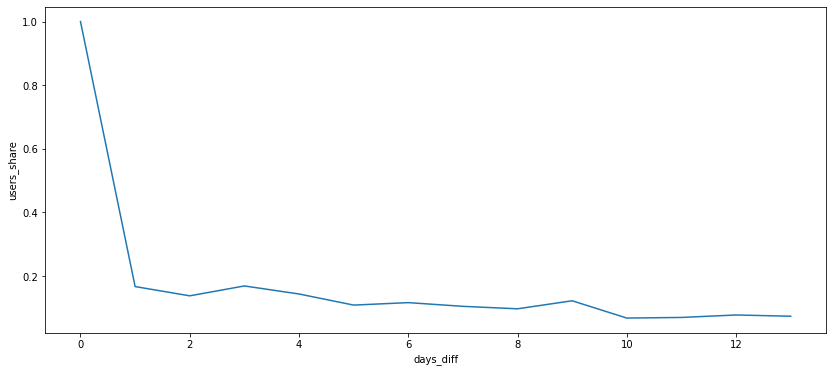

In [135]:
plt.figure(figsize = (14, 6))
sns.lineplot(data = retention_rate_control, x = 'days_diff', y = 'users_share')

*Экспериментальная группа - с новым алгоритмом*

In [136]:
first_orders_experimental = accepted_orders_info.query('group == 1')[['user_id', 'date']]

In [137]:
first_orders_experimental.head()

,user_id,date
4,965,2022-08-26
5,965,2022-08-26
6,965,2022-08-26
13,967,2022-08-26
14,967,2022-08-26


In [138]:
first_orders_experimental['first_order_date'] = first_orders_experimental.groupby('user_id')['date'].transform(min)

In [139]:
first_orders_experimental.head()

,user_id,date,first_order_date
4,965,2022-08-26,2022-08-26
5,965,2022-08-26,2022-08-26
6,965,2022-08-26,2022-08-26
13,967,2022-08-26,2022-08-26
14,967,2022-08-26,2022-08-26


In [140]:
retention_rate_experimental = first_orders_experimental \
    .groupby(['first_order_date', 'date'], as_index = False) \
    .agg({'user_id': 'nunique'}) \
    .rename(columns = {'user_id': 'users_count'})

retention_rate_experimental['max_users'] = retention_rate_experimental.groupby('first_order_date')['users_count'].transform(max)

retention_rate_experimental = retention_rate_experimental.assign(users_share = retention_rate_experimental.users_count / retention_rate_experimental.max_users)

retention_rate_experimental['days_diff'] = (retention_rate_experimental.date - retention_rate_experimental.first_order_date).dt.days

In [141]:
retention_rate_experimental

,first_order_date,date,users_count,max_users,users_share,days_diff
0,2022-08-26,2022-08-26,502,502,1.000000,0
1,2022-08-26,2022-08-27,133,502,0.264940,1
2,2022-08-26,2022-08-28,134,502,0.266932,2
3,2022-08-26,2022-08-29,136,502,0.270916,3
4,2022-08-26,2022-08-30,99,502,0.197211,4
5,2022-08-26,2022-08-31,92,502,0.183267,5
6,2022-08-26,2022-09-01,88,502,0.175299,6
7,2022-08-26,2022-09-02,87,502,0.173307,7
8,2022-08-26,2022-09-03,89,502,0.177291,8
9,2022-08-26,2022-09-04,89,502,0.177291,9


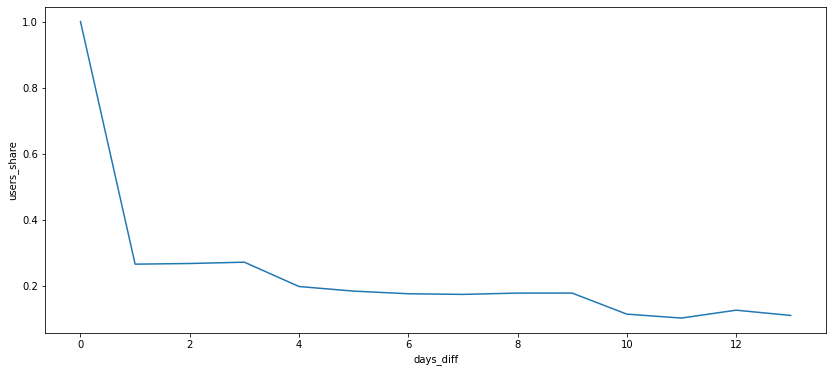

In [142]:
plt.figure(figsize = (14, 6))
sns.lineplot(data = retention_rate_experimental, x = 'days_diff', y = 'users_share')

*Теперь посмотрим на Retention в обоих группах*

In [143]:
retention_two_groups = retention_rate_control[['days_diff', 'users_share']] \
    .merge(retention_rate_experimental[['days_diff', 'users_share']], on = 'days_diff', how = 'inner') \
    .rename(columns = {'users_share_x': 'users_share_control', 'users_share_y': 'users_share_experimental'}) \
    .set_index('days_diff')

In [144]:
retention_style = (retention_two_groups.transpose()
            .style
            .set_caption('User Retention: Cohort 2022-08-26')  # добавляем подпись
            .background_gradient(cmap='cividis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
retention_style

days_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13
users_share_control,100.00%,16.70%,13.79%,16.89%,14.37%,10.87%,11.65%,10.49%,9.71%,12.23%,6.80%,6.99%,7.77%,7.38%
users_share_experimental,100.00%,26.49%,26.69%,27.09%,19.72%,18.33%,17.53%,17.33%,17.73%,17.73%,11.35%,10.16%,12.55%,10.96%


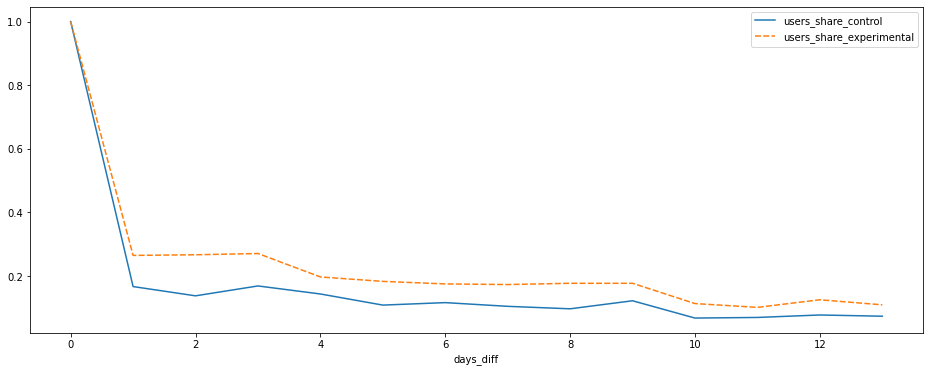

In [145]:
plt.figure(figsize = (16, 6))
sns.lineplot(data = retention_two_groups)

*Заметно, что Retention Rate в экспериментальной группе выше. Как обычно, проверим это с помощью стат. тестов*

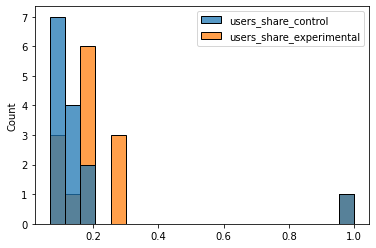

In [146]:
sns.histplot(retention_two_groups)

*Распределение получилось ненормальным для обоих групп, также с выбросами. Поэтому воспользуемся непараметрическим критерием Манна-Уитни*

In [147]:
stats.mannwhitneyu(retention_two_groups['users_share_control'],
                   retention_two_groups['users_share_experimental'])

MannwhitneyuResult(statistic=37.5, pvalue=0.005822462360179158)

*p-value получился равным 0.006, что меньше порога значимости 0.05. Делаем вывод, что наши группы различаются стат. значимо*

---

## Выводы:
    1. Новый алгоритм позволил добиться увеличения в количестве заказов пользователей, а также положительно сказался на показателе Retention, т.е. пользователи охотнее возвращаются к нам с новым алгоритмом.
    2. Новый алгоритм не повлиял на средний чек заказа пользователей. По крайней мере, эксперименту не удалось зафиксировать стат. значимых различий. Возможно, p-value не сошелся с такой продолжительностью и выборкой эксперимента.
    3. Из п.1 и п.2 можно вывести следствие, что и выручка у нашего сервиса увеличилась. (Стат. значимо увеличились заказы, но никак не изменился средний чек заказа)

---

## Заключение: Новый алгоритм положительно сказался на продукте. Его стоит включить в финальную версию приложения.